<a href="https://colab.research.google.com/github/LizcanoJuan1010/Machine-Learning-Projects/blob/main/Project_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto de CNN**
##Integrantes:
* Maria Fernanda Del Corral
* Juan José Lizcano
* David Alfonso Santiago Gómez

In [ ]:
!pip install -q kaggle

##Objetivo: Entrenar una modelo de aprendizaje profundo mejor conocido como deep learning, en particular un red neuronal convolucional (CNN), que pueda clasificar imagenes de rayos X de torax y detectar la presencia de neumonia o COVID-19 en pacientes medicos.

#PASO 0: Descarga y obtencion de los datos

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json #Se hace esto por seguridad y es para que el archivo de la API de kaggle sea de solo lectoruta (En mi caso como propietario tengo ambas)

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 772M/778M [00:09<00:00, 89.8MB/s]
100% 778M/778M [00:09<00:00, 84.6MB/s]


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:10<00:00, 279MB/s]
100% 2.29G/2.29G [00:10<00:00, 244MB/s]


In [ ]:
!unzip covid19-radiography-database.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Nor

In [ ]:
!unzip chest-xray-pneumonia.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpe

#PASO 1: Importacion de librerias

In [ ]:

#  LIBRERÍAS PARA VISUALIZACIÓN DE DATOS Y ANÁLISIS EXPLORATORIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#  LIBRERÍAS PARA MANIPULACIÓN DE DATOS Y SISTEMA DE ARCHIVOS
import os
import pandas as pd
import random
#  LIBRERÍAS PARA PROCESAMIENTO DE IMÁGENES
from PIL import Image
import cv2
import numpy as np

#  LIBRERÍAS PARA PREPARACIÓN DE DATOS (ESPECÍFICO PARA DEEP LEARNING)
import shutil

#  LIBRERÍAS PARA CONSTRUCCIÓN Y ENTRENAMIENTO DE MODELOS DE DEEP LEARNING
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

#  LIBRERÍAS PARA AUMENTO DE DATOS (DATA AUGMENTATION)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generador de imágenes para aumento de datos y preprocesamiento en tiempo real.
#FALATAN LAS LIBRERIAS QUE SE USARAN EN EL MODELO!

#PASO 2: Analisis Exploratorio de Datos (EDA)

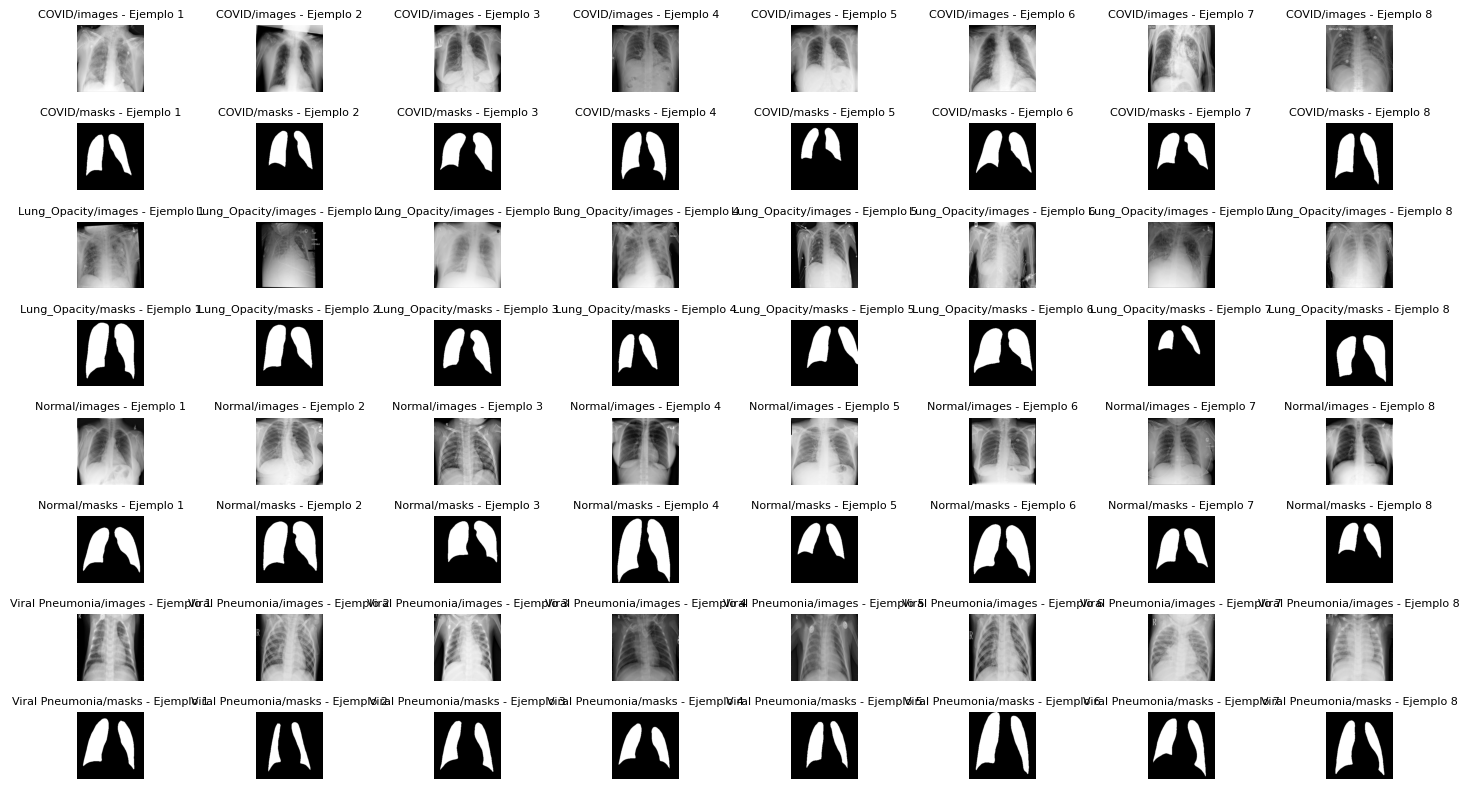

In [ ]:

ruta_dataset_principal = "COVID-19_Radiography_Dataset"

clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
subcarpetas = ['images', 'masks']

n_filas = 4
n_columnas_por_clase = 8

fig, axes = plt.subplots(len(clases) * len(subcarpetas), n_columnas_por_clase, figsize=(15, len(clases) * 2))

for i, clase in enumerate(clases):
    for k, subcarpeta in enumerate(subcarpetas):
        ruta_clase = os.path.join(ruta_dataset_principal, clase, subcarpeta)

        if not os.path.exists(ruta_clase):
            print(f"Directory not found: {ruta_clase}")
            continue

        imagenes_en_clase = os.listdir(ruta_clase)


        imagenes_en_clase = [img for img in imagenes_en_clase if os.path.isfile(os.path.join(ruta_clase, img))]


        if not imagenes_en_clase:
            print(f"No image files found in directory: {ruta_clase}")
            continue

        for j in range(min(n_columnas_por_clase, len(imagenes_en_clase))):
            imagen_aleatoria = random.choice(imagenes_en_clase)
            ruta_imagen = os.path.join(ruta_clase, imagen_aleatoria)

            img = mpimg.imread(ruta_imagen)


            ax = axes[i * len(subcarpetas) + k, j]

            ax.imshow(img, cmap='gray')
            ax.set_title(f'{clase}/{subcarpeta} - Ejemplo {j + 1}', fontsize=8)
            ax.axis('off')

plt.tight_layout()
plt.show()

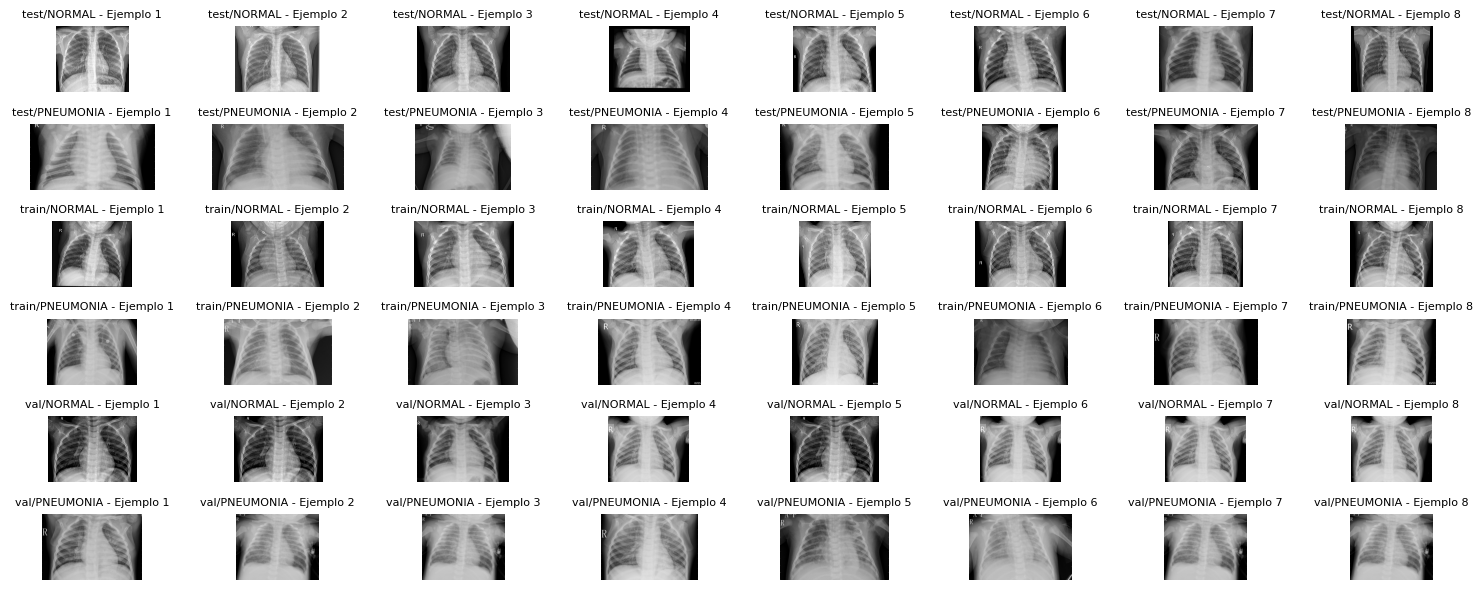

In [ ]:
ruta_dataset_principal = "chest_xray"

clases = ['test', 'train', 'val']
subcarpetas = ['NORMAL', 'PNEUMONIA']

n_filas = 4
n_columnas_por_clase = 8

fig, axes = plt.subplots(len(clases) * len(subcarpetas), n_columnas_por_clase, figsize=(15, len(clases) * 2))

for i, clase in enumerate(clases):
    for k, subcarpeta in enumerate(subcarpetas):
        ruta_clase = os.path.join(ruta_dataset_principal, clase, subcarpeta)

        if not os.path.exists(ruta_clase):
            print(f"Directory not found: {ruta_clase}")
            continue

        imagenes_en_clase = os.listdir(ruta_clase)


        imagenes_en_clase = [img for img in imagenes_en_clase if os.path.isfile(os.path.join(ruta_clase, img))]


        if not imagenes_en_clase:
            print(f"No image files found in directory: {ruta_clase}")
            continue

        for j in range(min(n_columnas_por_clase, len(imagenes_en_clase))):
            imagen_aleatoria = random.choice(imagenes_en_clase)
            ruta_imagen = os.path.join(ruta_clase, imagen_aleatoria)

            img = mpimg.imread(ruta_imagen)


            ax = axes[i * len(subcarpetas) + k, j]

            ax.imshow(img, cmap='gray')
            ax.set_title(f'{clase}/{subcarpeta} - Ejemplo {j + 1}', fontsize=8)
            ax.axis('off')

plt.tight_layout()
plt.show()

             Clase  Cantidad_Imagenes
0            COVID               3616
1     Lung_Opacity               6012
2           Normal              10192
3  Viral Pneumonia               1345


<ipython-input-11-e4e778fcc5fe>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis") # 'viridis' es una paleta de colores


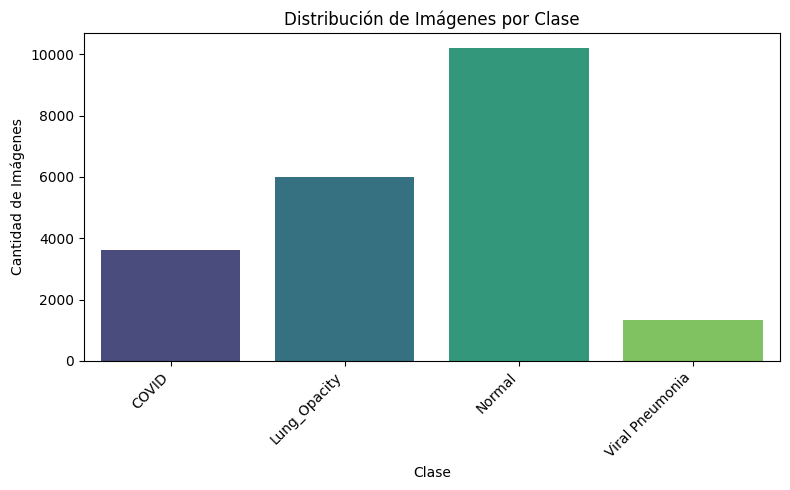

In [ ]:


ruta_dataset_principal = "COVID-19_Radiography_Dataset"
clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
subcarpetas = ['images', 'masks']
conteo_imagenes_por_clase = {}

for clase in clases:

    ruta_clase = os.path.join(ruta_dataset_principal, clase,'images')
    num_imagenes = len(os.listdir(ruta_clase))
    conteo_imagenes_por_clase[clase] = num_imagenes

df_distribucion = pd.DataFrame(list(conteo_imagenes_por_clase.items()), columns=['Clase', 'Cantidad_Imagenes'])
print(df_distribucion)


plt.figure(figsize=(8, 5))
sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis")
plt.title('Distribución de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

   Clase  Cantidad_Imagenes
0   test                390
1  train               3875
2    val                  8


<ipython-input-12-86705b243733>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis") # 'viridis' es una paleta de colores


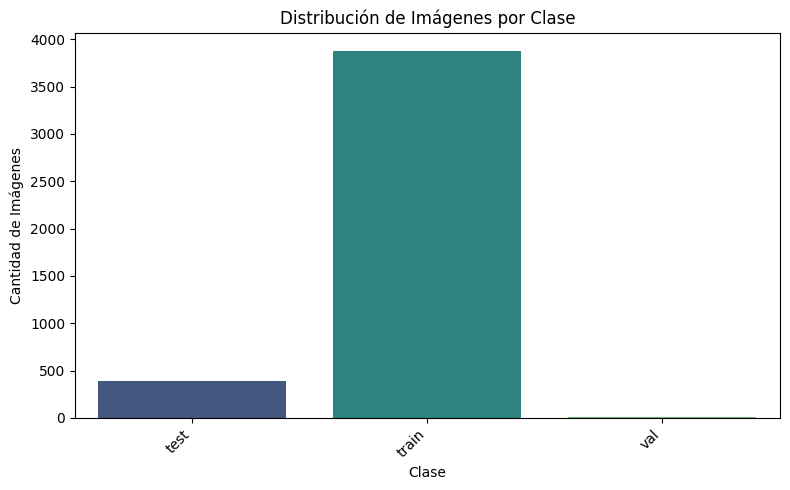

In [ ]:
ruta_dataset_principal = "chest_xray"

clases = ['test', 'train', 'val']
subcarpetas = ['NORMAL', 'PNEUMONIA']
conteo_imagenes_por_clase = {}

for clase in clases:
  for subcarpeta in subcarpetas:
    ruta_clase = os.path.join(ruta_dataset_principal, clase,subcarpeta)
    num_imagenes = len(os.listdir(ruta_clase))
    conteo_imagenes_por_clase[clase] = num_imagenes

df_distribucion = pd.DataFrame(list(conteo_imagenes_por_clase.items()), columns=['Clase', 'Cantidad_Imagenes'])
print(df_distribucion) # Mostrar tabla


plt.figure(figsize=(8, 5))
sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis")
plt.title('Distribución de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

   Clase   Nombre_Imagen  Ancho  Alto  Canales
0  COVID   COVID-387.png    299   299        1
1  COVID  COVID-3472.png    299   299        1
2  COVID  COVID-2667.png    299   299        1
3  COVID  COVID-3089.png    299   299        1
4  COVID   COVID-356.png    299   299        1
              Ancho          Alto       Canales
count  42330.000000  42330.000000  42330.000000
mean     277.500000    277.500000      2.006615
std       21.500254     21.500254      0.999990
min      256.000000    256.000000      1.000000
25%      256.000000    256.000000      1.000000
50%      277.500000    277.500000      3.000000
75%      299.000000    299.000000      3.000000
max      299.000000    299.000000      3.000000


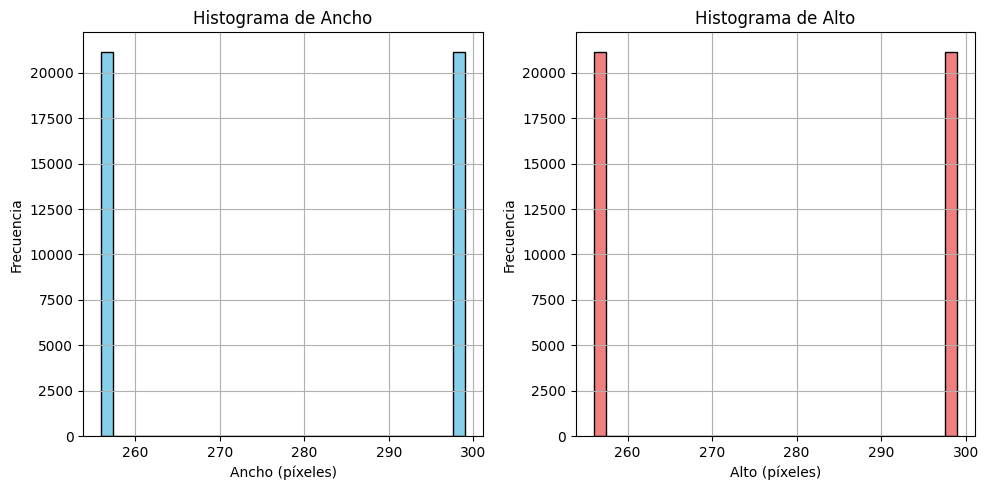

In [ ]:

ruta_dataset_principal = "COVID-19_Radiography_Dataset"
clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
subcarpetas = ['images', 'masks']
dimensiones_imagenes = []

for clase in clases:
  for subcarpeta in subcarpetas:
    ruta_clase = os.path.join(ruta_dataset_principal, clase, subcarpeta)
    for nombre_imagen in os.listdir(ruta_clase):
        ruta_imagen = os.path.join(ruta_clase, nombre_imagen)
        try:
            with Image.open(ruta_imagen) as img:
                ancho, alto = img.size
                canales = len(img.getbands())
                dimensiones_imagenes.append({'Clase': clase, 'Nombre_Imagen': nombre_imagen, 'Ancho': ancho, 'Alto': alto, 'Canales': canales})
        except Exception as e:
            print(f"Error al procesar imagen: {ruta_imagen} - {e}")

df_dimensiones = pd.DataFrame(dimensiones_imagenes)
print(df_dimensiones.head())
print(df_dimensiones.describe())


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df_dimensiones['Ancho'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Ancho')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df_dimensiones['Alto'].hist(bins=30, color='lightcoral', edgecolor='black')
plt.title('Histograma de Alto')
plt.xlabel('Alto (píxeles)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

  Clase              Nombre_Imagen  Ancho  Alto  Canales
0  test  NORMAL2-IM-0328-0001.jpeg   1338   967        1
1  test          IM-0016-0001.jpeg   2498  2057        1
2  test  NORMAL2-IM-0274-0001.jpeg   1646  1214        1
3  test  NORMAL2-IM-0297-0001.jpeg   1890  1334        1
4  test  NORMAL2-IM-0029-0001.jpeg   1928  1756        1
             Ancho         Alto      Canales
count  5856.000000  5856.000000  5856.000000
mean   1327.880806   970.689037     1.096653
std     363.500922   383.392117     0.428947
min     384.000000   127.000000     1.000000
25%    1056.000000   688.000000     1.000000
50%    1281.000000   888.000000     1.000000
75%    1560.000000  1187.000000     1.000000
max    2916.000000  2713.000000     3.000000


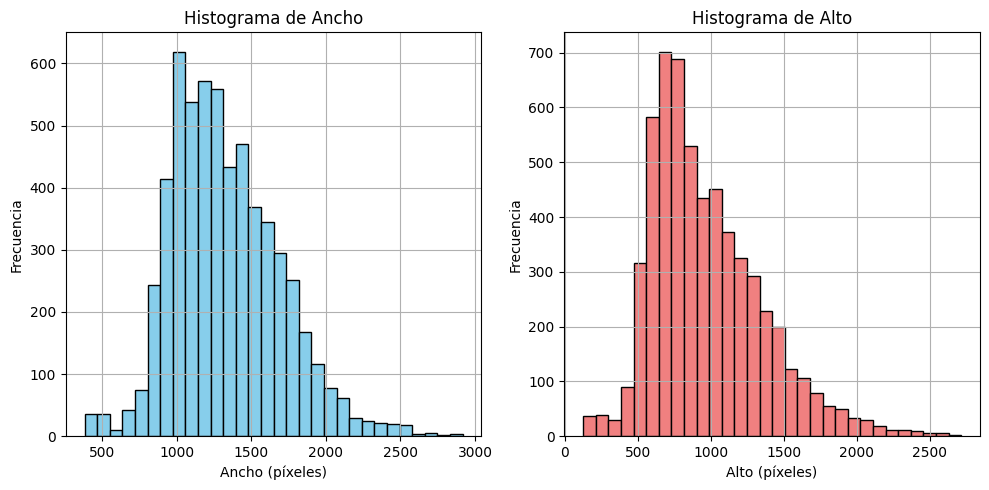

In [ ]:
ruta_dataset_principal = "chest_xray"

clases = ['test', 'train', 'val']
subcarpetas = ['NORMAL', 'PNEUMONIA']
dimensiones_imagenes = []

for clase in clases:
  for subcarpeta in subcarpetas:
    ruta_clase = os.path.join(ruta_dataset_principal, clase, subcarpeta)
    for nombre_imagen in os.listdir(ruta_clase):
        ruta_imagen = os.path.join(ruta_clase, nombre_imagen)
        try:
            with Image.open(ruta_imagen) as img:
                ancho, alto = img.size
                canales = len(img.getbands())
                dimensiones_imagenes.append({'Clase': clase, 'Nombre_Imagen': nombre_imagen, 'Ancho': ancho, 'Alto': alto, 'Canales': canales})
        except Exception as e:
            print(f"Error al procesar imagen: {ruta_imagen} - {e}")

df_dimensiones = pd.DataFrame(dimensiones_imagenes)
print(df_dimensiones.head())
print(df_dimensiones.describe())


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df_dimensiones['Ancho'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Ancho')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df_dimensiones['Alto'].hist(bins=30, color='lightcoral', edgecolor='black')
plt.title('Histograma de Alto')
plt.xlabel('Alto (píxeles)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

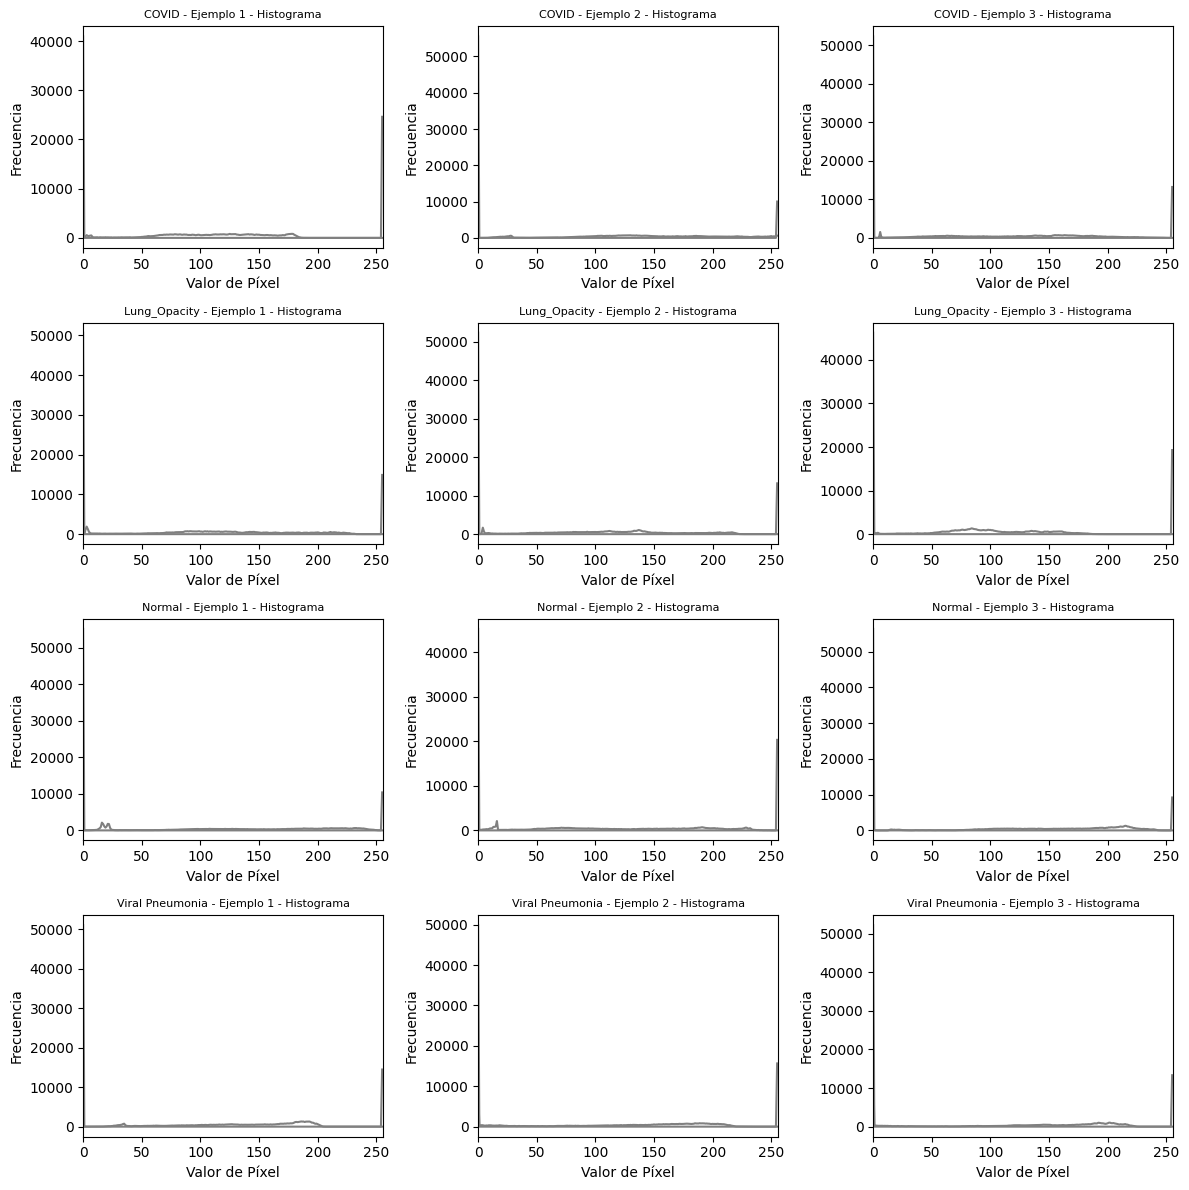

In [ ]:

ruta_dataset_principal = "COVID-19_Radiography_Dataset"
clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
subcarpetas = ['images', 'masks']
num_imagenes_histograma = 3

fig, axes = plt.subplots(len(clases), num_imagenes_histograma, figsize=(12, len(clases) * 3))

for i, clase in enumerate(clases):
  for k, subcarpeta in enumerate(subcarpetas):
    ruta_clase = os.path.join(ruta_dataset_principal, clase, subcarpeta)
    imagenes_en_clase = os.listdir(ruta_clase)

    for j in range(num_imagenes_histograma):
        imagen_aleatoria = random.choice(imagenes_en_clase)
        ruta_imagen = os.path.join(ruta_clase, imagen_aleatoria)

        img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            histr = cv2.calcHist([img],[0],None,[256],[0,256])
            ax = axes[i, j]
            ax.plot(histr, color='gray')
            ax.set_xlim([0,256])
            ax.set_title(f'{clase} - Ejemplo {j+1} - Histograma', fontsize=8)
            ax.set_xlabel('Valor de Píxel')
            ax.set_ylabel('Frecuencia')
        else:
            print(f"No se pudo cargar la imagen: {ruta_imagen}")
            ax = axes[i, j]
            ax.text(0.5, 0.5, 'Error al cargar imagen', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

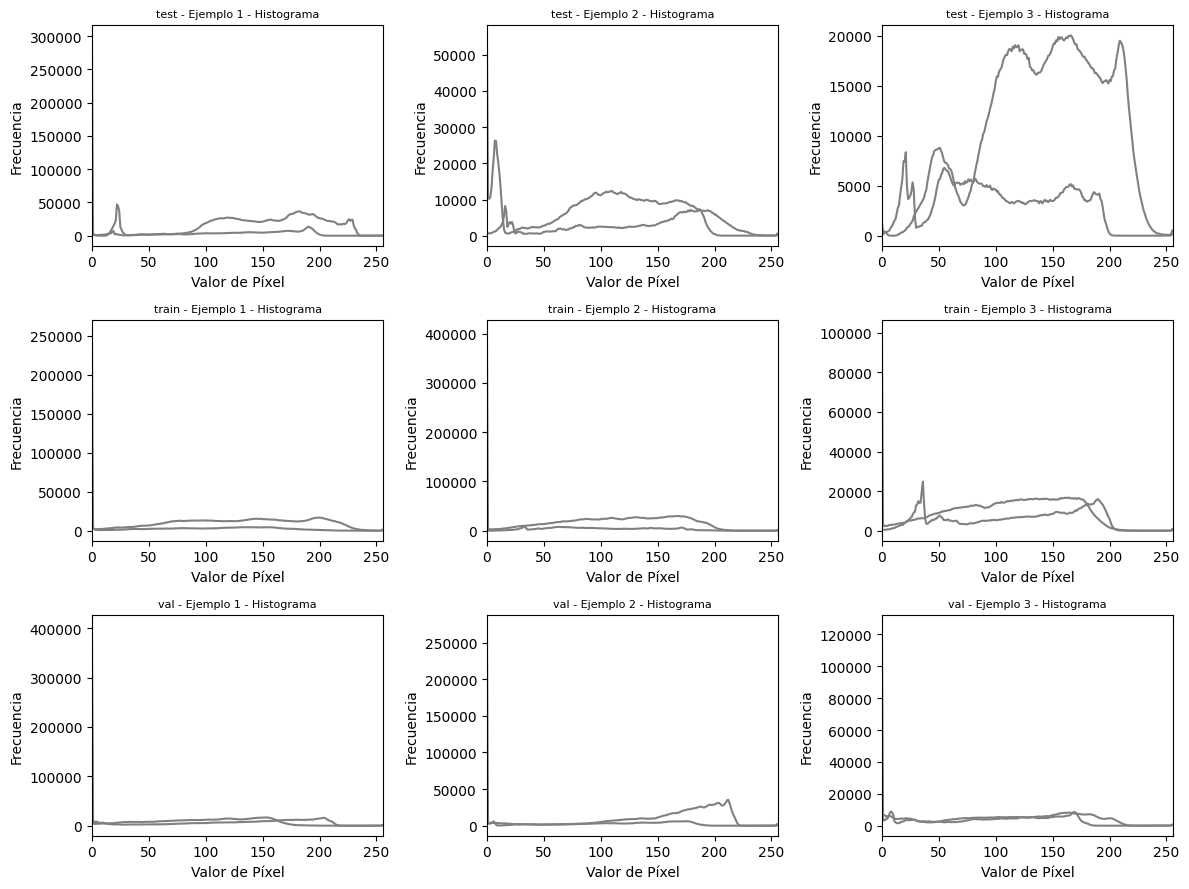

In [ ]:
ruta_dataset_principal = "chest_xray"

clases = ['test', 'train', 'val']
subcarpetas = ['NORMAL', 'PNEUMONIA']
num_imagenes_histograma = 3

fig, axes = plt.subplots(len(clases), num_imagenes_histograma, figsize=(12, len(clases) * 3))

for i, clase in enumerate(clases):
  for k, subcarpeta in enumerate(subcarpetas):
    ruta_clase = os.path.join(ruta_dataset_principal, clase, subcarpeta)
    imagenes_en_clase = os.listdir(ruta_clase)

    for j in range(num_imagenes_histograma):
        imagen_aleatoria = random.choice(imagenes_en_clase)
        ruta_imagen = os.path.join(ruta_clase, imagen_aleatoria)

        img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            histr = cv2.calcHist([img],[0],None,[256],[0,256])
            ax = axes[i, j]
            ax.plot(histr, color='gray')
            ax.set_xlim([0,256])
            ax.set_title(f'{clase} - Ejemplo {j+1} - Histograma', fontsize=8)
            ax.set_xlabel('Valor de Píxel')
            ax.set_ylabel('Frecuencia')
        else:
            print(f"No se pudo cargar la imagen: {ruta_imagen}")
            ax = axes[i, j]
            ax.text(0.5, 0.5, 'Error al cargar imagen', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

Luego de analizar las imagenes que teniamos para poder hacer el modelo decidimos usar unicamente el primer dataset llamadao COVID-19_Radiography_Dataset, y ademas de eso decidimos no usar imagenes de tipo mascara (Masks) para facilitar el desarrollo de la red convolucional

#PASO 3: Preparacion de imagenes y preprocesamiento

Se creo una funcion en la cual se van a normalizar las imagenes de las carpetas, en esta misma funcion de normalizan, cambia el tamaño de las mismas a 256 * 256 y se reduce el ruido dentro de cada cosa

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def resize_clahe_denoise_normalize_images(input_folder, output_folder, target_size=(256, 256), interpolation_method=cv2.INTER_AREA,
                                         clahe_clip_limit=2.0, clahe_tile_size=(8, 8), denoise=False, denoise_kernel_size=(5, 5),
                                         augment_non_normal=False, max_augmented_images=3):

    os.makedirs(output_folder, exist_ok=True)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_size)


    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"No se pudo leer la imagen: {filename}")
                continue

            img_resized = cv2.resize(img, target_size, interpolation=interpolation_method)

            if denoise:
                img_resized = cv2.GaussianBlur(img_resized, denoise_kernel_size, 0)

            img_clahe = clahe.apply(img_resized)

            img_normalized = img_clahe / 255.0


            cv2.imwrite(output_path, (img_normalized * 255).astype(np.uint8))
            print(f"Imagen redimensionada, CLAHE aplicada, normalizada y guardada: {filename} a tamaño {target_size}")


            if augment_non_normal and "Normal" not in input_folder:
                img_expanded = np.expand_dims(img_normalized, axis=-1)
                img_expanded = np.expand_dims(img_expanded, axis=0)

                batch_count = 0
                for batch in datagen.flow(img_expanded, batch_size=1):
                    augmented_image = batch[0, :, :, 0]
                    augmented_image_uint8 = (augmented_image * 255).astype(np.uint8)


                    base_name, ext = os.path.splitext(filename)
                    output_filename_aug = f"{base_name}_aug_{batch_count}{ext}"
                    output_path_augmented = os.path.join(output_folder, output_filename_aug)


                    cv2.imwrite(output_path_augmented, augmented_image_uint8)
                    print(f"Imagen aumentada y guardada: {output_filename_aug}")

                    batch_count += 1
                    if batch_count >= max_augmented_images:
                        break



ruta_dataset_principal = "COVID-19_Radiography_Dataset"
clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
subcarpetas = ['images', 'masks']
carpeta_base_output = '/content/dataset_redimensionado'

os.makedirs(carpeta_base_output, exist_ok=True)

for clase in clases:
    for subcarpeta in subcarpetas:
        ruta_clase_input = os.path.join(ruta_dataset_principal, clase, subcarpeta)
        ruta_clase_output = os.path.join(carpeta_base_output, clase, subcarpeta)
        os.makedirs(ruta_clase_output, exist_ok=True)

        target_image_size = (256, 256)
        interpolation_method_to_use = cv2.INTER_AREA
        clahe_clip_limit = 2.0
        clahe_tile_size = (8, 8)
        usar_denoise = True
        denoise_kernel_size_val = (5, 5)
        augment_non_normal = True
        max_augmented_images = 3

        print(f"Procesando imágenes de: {ruta_clase_input} a {ruta_clase_output}")
        resize_clahe_denoise_normalize_images(
            ruta_clase_input, ruta_clase_output, target_image_size, interpolation_method_to_use,
            clahe_clip_limit, clahe_tile_size, usar_denoise, denoise_kernel_size_val,
            augment_non_normal, max_augmented_images
        )

print("Proceso de preprocesamiento y data augmentation completado.")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Imagen aumentada y guardada: Viral Pneumonia-273_aug_0.png
Imagen aumentada y guardada: Viral Pneumonia-273_aug_1.png
Imagen aumentada y guardada: Viral Pneumonia-273_aug_2.png
Imagen redimensionada, CLAHE aplicada, normalizada y guardada: Viral Pneumonia-1110.png a tamaño (256, 256)
Imagen aumentada y guardada: Viral Pneumonia-1110_aug_0.png
Imagen aumentada y guardada: Viral Pneumonia-1110_aug_1.png
Imagen aumentada y guardada: Viral Pneumonia-1110_aug_2.png
Imagen redimensionada, CLAHE aplicada, normalizada y guardada: Viral Pneumonia-440.png a tamaño (256, 256)
Imagen aumentada y guardada: Viral Pneumonia-440_aug_0.png
Imagen aumentada y guardada: Viral Pneumonia-440_aug_1.png
Imagen aumentada y guardada: Viral Pneumonia-440_aug_2.png
Imagen redimensionada, CLAHE aplicada, normalizada y guardada: Viral Pneumonia-357.png a tamaño (256, 256)
Imagen aumentada y guardada: Viral Pneumonia-357_aug_0.png
Imagen aumentada y

             Clase  Cantidad_Imagenes
0            COVID              14464
1           Normal              10192
2  Viral Pneumonia               5380


<ipython-input-7-23a8a0cfa4a5>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis") # 'viridis' es una paleta de colores


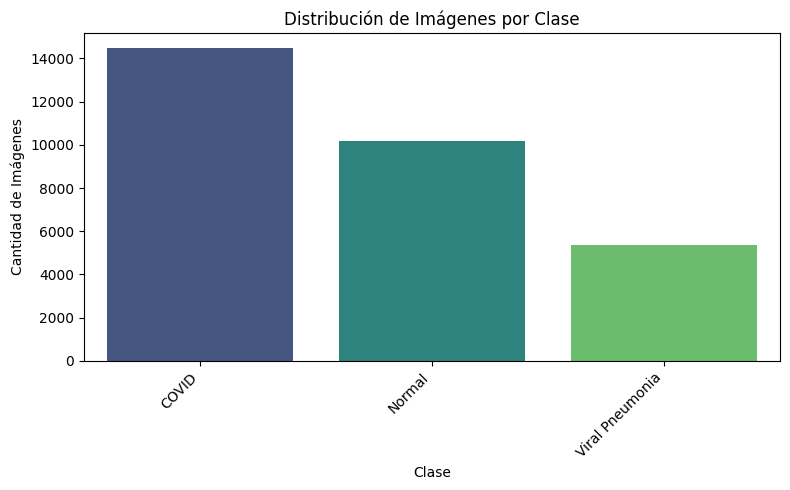

In [ ]:
ruta_dataset_principal = "/content/dataset_redimensionado"

clases = ['COVID', 'Normal','Viral Pneumonia']
subcarpetas = ['images']
conteo_imagenes_por_clase = {}

for clase in clases:
  for subcarpeta in subcarpetas:
    ruta_clase = os.path.join(ruta_dataset_principal, clase,subcarpeta)
    num_imagenes = len(os.listdir(ruta_clase))
    conteo_imagenes_por_clase[clase] = num_imagenes

df_distribucion = pd.DataFrame(list(conteo_imagenes_por_clase.items()), columns=['Clase', 'Cantidad_Imagenes'])
print(df_distribucion)


plt.figure(figsize=(8, 5))
sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis")
plt.title('Distribución de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#PASO 4: Separacion de los datos

Para poder separar los datos se decidio crear una carpeta en donde se separan los datos de testing, validacion y entrenamiento

In [ ]:
import os
import random
import shutil

def crear_dataset_split(ruta_dataset_original, ruta_dataset_split, clases, subcarpeta_imagenes='images',
                        porcentaje_validacion=0.15, porcentaje_test=0.15, semilla_aleatoria=42, max_imagenes_por_clase=5380):

    random.seed(semilla_aleatoria)


    os.makedirs(ruta_dataset_split, exist_ok=True)


    conjuntos = ['train', 'validation', 'test']
    for conjunto in conjuntos:
        for clase in clases:
            os.makedirs(os.path.join(ruta_dataset_split, conjunto, clase), exist_ok=True)

    for clase in clases:

        ruta_imagenes_clase = os.path.join(ruta_dataset_original, clase, subcarpeta_imagenes)


        imagenes_nombres = os.listdir(ruta_imagenes_clase)
        imagenes_rutas_clase = [
            os.path.join(ruta_imagenes_clase, nombre)
            for nombre in imagenes_nombres
            if nombre.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))
        ]


        random.shuffle(imagenes_rutas_clase)


        if len(imagenes_rutas_clase) > max_imagenes_por_clase:
            imagenes_rutas_clase = imagenes_rutas_clase[:max_imagenes_por_clase]


        num_imagenes = len(imagenes_rutas_clase)
        num_validacion = int(num_imagenes * porcentaje_validacion)
        num_test = int(num_imagenes * porcentaje_test)
        num_train = num_imagenes - num_validacion - num_test


        indices = {
            'train': (0, num_train),
            'validation': (num_train, num_train + num_validacion),
            'test': (num_train + num_validacion, num_imagenes)
        }


        for conjunto in conjuntos:
            start_index, end_index = indices[conjunto]
            for i in range(start_index, end_index):
                ruta_imagen_original = imagenes_rutas_clase[i]
                nombre_imagen = os.path.basename(ruta_imagen_original)
                ruta_destino = os.path.join(ruta_dataset_split, conjunto, clase, nombre_imagen)
                shutil.copyfile(ruta_imagen_original, ruta_destino)

            print(f"Copiadas {end_index - start_index} imágenes de la clase {clase} al conjunto {conjunto}")

    print(f"Dataset dividido creado en: {ruta_dataset_split}")



ruta_dataset_original_imagenes = 'dataset_redimensionado'
ruta_dataset_split_destino = 'dataset_split2'
clases_dataset = ['COVID', 'Normal', 'Viral Pneumonia']
subcarpeta_imagenes_nombre = 'images'

crear_dataset_split(
    ruta_dataset_original_imagenes,
    ruta_dataset_split_destino,
    clases_dataset,
    subcarpeta_imagenes_nombre,
    max_imagenes_por_clase=5380
)

Copiadas 3766 imágenes de la clase COVID al conjunto train
Copiadas 807 imágenes de la clase COVID al conjunto validation
Copiadas 807 imágenes de la clase COVID al conjunto test
Copiadas 3766 imágenes de la clase Normal al conjunto train
Copiadas 807 imágenes de la clase Normal al conjunto validation
Copiadas 807 imágenes de la clase Normal al conjunto test
Copiadas 3766 imágenes de la clase Viral Pneumonia al conjunto train
Copiadas 807 imágenes de la clase Viral Pneumonia al conjunto validation
Copiadas 807 imágenes de la clase Viral Pneumonia al conjunto test
Dataset dividido creado en: dataset_split2


        Clase  Cantidad_Imagenes
0        test               2421
1       train              11298
2  validation               2421


<ipython-input-9-b07ac3018740>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis")


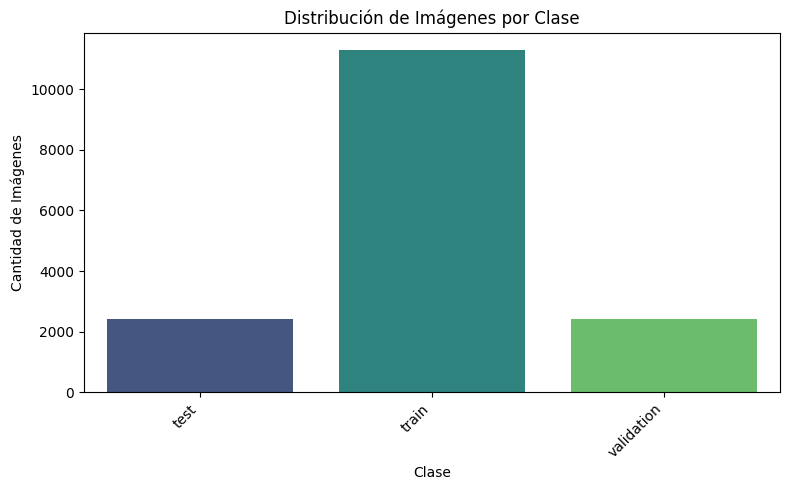

In [ ]:
ruta_dataset_principal = "/content/dataset_split2"

clases = ['test', 'train', 'validation']
subcarpetas = ['COVID', 'Normal','Viral Pneumonia']
conteo_imagenes_por_clase = {}

for clase in clases:
  img=0
  for subcarpeta in subcarpetas:
    ruta_clase = os.path.join(ruta_dataset_principal, clase,subcarpeta)
    num_imagenes = len(os.listdir(ruta_clase))
    img+=num_imagenes
  conteo_imagenes_por_clase[clase] = img

df_distribucion = pd.DataFrame(list(conteo_imagenes_por_clase.items()), columns=['Clase', 'Cantidad_Imagenes'])
print(df_distribucion)

plt.figure(figsize=(8, 5))
sns.barplot(x='Clase', y='Cantidad_Imagenes', data=df_distribucion, palette="viridis")
plt.title('Distribución de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#PASO 5: Aumento de datos

In [ ]:

img_height, img_width = 256, 256
batch_size = 32


directorio_train = 'dataset_split2/train'
directorio_validacion = 'dataset_split2/validation'
directorio_test = 'dataset_split2/test'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directorio_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    directorio_validacion,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directorio_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42
)


print("Información del generador de entrenamiento:")
print(train_generator.class_indices)
print(f"Número de batches de entrenamiento por época: {len(train_generator)}")
print(f"Número de imágenes de entrenamiento: {train_generator.samples}")

print("\nInformación del generador de validación:")
print(validation_generator.class_indices)
print(f"Número de batches de validación: {len(validation_generator)}")
print(f"Número de imágenes de validación: {validation_generator.samples}")

print("\nInformación del generador de prueba:")
print(test_generator.class_indices)
print(f"Número de batches de prueba: {len(test_generator)}")
print(f"Número de imágenes de prueba: {test_generator.samples}")

print("\nData augmentation configurado y generadores de datos listos.")


Found 11298 images belonging to 3 classes.
Found 2421 images belonging to 3 classes.
Found 2421 images belonging to 3 classes.
Información del generador de entrenamiento:
{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}
Número de batches de entrenamiento por época: 354
Número de imágenes de entrenamiento: 11298

Información del generador de validación:
{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}
Número de batches de validación: 76
Número de imágenes de validación: 2421

Información del generador de prueba:
{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}
Número de batches de prueba: 76
Número de imágenes de prueba: 2421

Data augmentation configurado y generadores de datos listos.


#PASO 6: Reentrenamiento del modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D
import os
import matplotlib.pyplot as plt


In [ ]:

ruta_dataset_principal = "/content/dataset_split2"

train_dir = os.path.join(ruta_dataset_principal, "train")
val_dir = os.path.join(ruta_dataset_principal, "validation")
test_dir = os.path.join(ruta_dataset_principal, "test")

img_size = (256, 256)
batch_size = 32


In [ ]:

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    color_mode='grayscale'
)

val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    color_mode='grayscale'
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    color_mode='grayscale'
)


num_classes = len(train_generator.class_names)
print(f"Clases detectadas: {train_generator.class_names}")


Found 11298 files belonging to 3 classes.
Found 2421 files belonging to 3 classes.
Found 2421 files belonging to 3 classes.
Clases detectadas: ['COVID', 'Normal', 'Viral Pneumonia']


In [ ]:
modelo_path = "modelo_vgg16.h5"


input_tensor = Input(shape=(256, 256, 1))


x = Conv2D(3, (3, 3), padding='same')(input_tensor)


base_model = VGG16(weights=None, include_top=False, input_tensor=x)



for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
])


model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)


print("Modelo creado desde cero.")

Modelo creado desde cero.


In [ ]:

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_30']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


354/354 ━━━━━━━━━━━━━━━━━━━━ 102s 277ms/step - accuracy: 0.5216 - loss: 0.9659 - val_accuracy: 0.7972 - val_loss: 0.5400
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 95s 268ms/step - accuracy: 0.7533 - loss: 0.5976 - val_accuracy: 0.8021 - val_loss: 0.4851
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 95s 267ms/step - accuracy: 0.7952 - loss: 0.5185 - val_accuracy: 0.8381 - val_loss: 0.3983
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 142s 267ms/step - accuracy: 0.8182 - loss: 0.4540 - val_accuracy: 0.8645 - val_loss: 0.3524
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 99s 279ms/step - accuracy: 0.8397 - loss: 0.4146 - val_accuracy: 0.8629 - val_loss: 0.3596
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 142s 279ms/step - accuracy: 0.8401 - loss: 0.4077 - val_accuracy: 0.8786 - val_loss: 0.3150
Epoch 7/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 138s 268ms/step - accuracy: 0.8489 - loss: 0.3871 - val_accuracy: 0.8843 - val_loss: 0.3029
Epoch 8/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 95s 268ms/step - accuracy: 0.8592 - loss: 0.3595 -

In [ ]:
model.save(modelo_path)
print("Modelo guardado en", modelo_path)


Modelo guardado en modelo_vgg16.h5


In [ ]:
eval_loss, eval_acc = model.evaluate(test_generator)
print(f"Precisión en test: {eval_acc*100:.2f}%")
model.save(modelo_path)

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.9147 - loss: 0.2171


Precisión en test: 91.82%


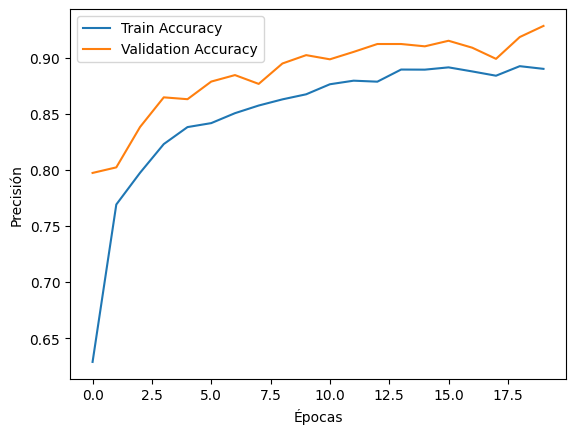

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [ ]:
import numpy as np


predicciones = model.predict(test_generator)
clases_predichas_indices = np.argmax(predicciones, axis=1)


clases_verdaderas_indices = []
for _, labels_batch in test_generator:
    clases_verdaderas_indices.extend(np.argmax(labels_batch, axis=1))

clases_verdaderas_indices = np.array(clases_verdaderas_indices)

nombres_clases = ['COVID', 'Normal', 'Viral Pneumonia']


num_ejemplos = 100
contador = 0

for i in range(num_ejemplos):
    print(f"Imagen {i+1}:")
    print(f"  Clase Verdadera: {nombres_clases[clases_verdaderas_indices[i]]}")
    print(f"  Clase Predicha: {nombres_clases[clases_predichas_indices[i]]}")
    print(f"  Probabilidades: {predicciones[i]}")
    print("-" * 30)


    if clases_verdaderas_indices[i] == clases_predichas_indices[i]:
        contador += 1


porcentaje_correcto = (contador / num_ejemplos) * 100
print(f"Porcentaje de predicciones correctas: {porcentaje_correcto:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step
Imagen 1:
  Clase Verdadera: Viral Pneumonia
  Clase Predicha: Normal
  Probabilidades: [1.5101080e-02 9.8489583e-01 3.0265808e-06]
------------------------------
Imagen 2:
  Clase Verdadera: COVID
  Clase Predicha: Viral Pneumonia
  Probabilidades: [3.8438913e-04 1.3173429e-03 9.9829835e-01]
------------------------------
Imagen 3:
  Clase Verdadera: COVID
  Clase Predicha: Viral Pneumonia
  Probabilidades: [0.00206037 0.00205136 0.9958883 ]
------------------------------
Imagen 4:
  Clase Verdadera: Normal
  Clase Predicha: COVID
  Probabilidades: [5.8033687e-01 4.1910756e-01 5.5556261e-04]
------------------------------
Imagen 5:
  Clase Verdadera: Viral Pneumonia
  Clase Predicha: Normal
  Probabilidades: [6.9111876e-02 9.3082178e-01 6.6305773e-05]
------------------------------
Imagen 6:
  Clase Verdadera: Normal
  Clase Predicha: Viral Pneumonia
  Probabilidades: [0.00248368 0.04473807 0.9527783 ]
------------------------------
Imagen 7:
